### Adaptive Fault Detection with VAR Models

##### Import libraries needed

In [101]:
# importing packages and libraries
from pandas import read_csv
import pandas as pd
import numpy as np
import pickle
import os
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

# Ignoe harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Define the plot size default
from pylab import rcParams
rcParams['figure.figsize'] = (12, 5)

### Defining methods or functions

In [102]:
# Plotting multiple series
def plot_multiple_series(actual, pred, attr):
    for i in range(len(attr)):
        title = "Prediction of {}".format(attr[i])
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel("Values")
        plt.plot(actual.iloc[:,i], label="actual")
        plt.plot(pred.iloc[:,i], label="forecast")
        plt.legend()
        plt.show()


# Root mean squared error
def root_mse(x, y):
    if len(x) != len(y):
        return "Error: The two arguments must have the same length"
    mse = np.square(np.subtract(x, y)).mean()
    return np.sqrt(mse)

# Plotting series
def plot_series(series, attr):
    for i in range(len(attr)):
        title = "Plot of "+str(attr[i])
        actual = series.iloc[:,i]
        plt.title(title)
        plt.xlabel("Timestep")
        plt.ylabel(attr[i])
        plt.plot(actual)
        plt.show()

# Normalisation of time series
def normalise_timeseries(data):
    # Calculate the mean and standard deviation for each feature
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    
    # Normalise each feature using standard deviation
    normalised_data = (data - means) / stds
    return pd.DataFrame(normalised_data)


# Denomalisation of time series
def denormalise_timeseries(data, means, stds):
    denormalised_data = (data * stds) + means
    return pd.DataFrame(denormalised_data)


# Augmented Dickey-Fuller Test
def adf_test(series, title=''):
    '''
    Hypothesis Test for Stationarity
    Pass in a time series and an optional title, return an ADF report
    '''
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC')
    labels = ['ADF test statistics','p-value','#lags','#observations'] # use help(adfuller) to understand why these labels are chosen
    
    outcome = pd.Series(result[0:4],index=labels)
    
    for key,val in result[4].items():
        outcome[f'critical value ({key})'] = val
        
    print(outcome.to_string()) # this will not print the line 'dtype:float64'
    
    if result[1] <= 0.05:
        print('Strong evidence against the null hypothesis') # Ho is Data is not stationary, check help(adfuller)
        print('Reject the null hypothesis')
        print('Data is Stationary')
    else:
        print('Weak evidence against the Null hypothesis')
        print('Fail to reject the null hypothesis')
        print('Data has a unit root and is non stationary')


# Loading expert models in a dictionary
def load_expert_models(expert_path):
    files = os.listdir(expert_path)
    pickle_files = [file for file in files if file.endswith('.pkl')]
    models = {}

    for file in pickle_files:
        with open(file, 'rb') as f:
            models[file.split('.')[0]] = pickle.load(f)

    return models


In [103]:
# Assigning variables
# file = 'test_series_reduced.csv'
# file = 'stuckat0_training_reduced.csv'
# file = 'valueflip_training_reduced.csv'
file = 'stuckat1_training_reduced.csv'
expert_path = 'expert_models'
df_raw = read_csv(file, header=0, index_col=0)
attr = list(pd.read_csv(file).columns.values)[1:]
series = df_raw.iloc[:40000,:]
# plot_series(series, attr)
nobs = 3000
steps = 15
begin = 2000
finish = 2200
normalised_data = normalise_timeseries(df_raw)
testData = normalised_data.copy()
train = testData.iloc[:-nobs]
test = testData.iloc[-nobs:]
# len(train), len(test)
input1 = testData.iloc[begin:finish,:]
# plot_series(input1, attr)
prediction_error = {}

In [104]:
# Threshold prediction error value
threshold = 0

In [105]:
# Load the expert models
my_experts = load_expert_models(expert_path)
# print(my_experts)
print(my_experts['var_ctrl_stuckat0_perm_reduced'])


In [106]:
pred = my_experts['var_ctrl_stuckat0_perm_reduced'].forecast(input1.values, steps=steps)
pred_df = pd.DataFrame(pred, columns=input1.columns)
print(pred_df)

    Tank2OutFlow  Tank2.puddle  Tank3OutFlow  Tank2.level  wt3_valve
0       0.189634     -1.193800     -0.601648     1.476853  -0.143181
1       0.168439     -1.193679      0.020413     1.477840   0.134610
2       0.154359     -1.193432      0.337780     1.453239   0.482134
3       0.169607     -1.192972      0.759027     1.371803   0.671490
4       0.196668     -1.192380      0.930040     1.264297   0.917704
5       0.190604     -1.191750      1.197966     1.135412   1.039974
6       0.159254     -1.190983      1.261781     0.980139   1.226894
7       0.155397     -1.190192      1.447618     0.825620   1.304622
8       0.181959     -1.189269      1.446405     0.641481   1.415889
9       0.197162     -1.188510      1.533455     0.479260   1.451814
10      0.181888     -1.187567      1.481175     0.287453   1.523576
11      0.160142     -1.186797      1.521409     0.128812   1.519721
12      0.161652     -1.185842      1.428298    -0.059500   1.543373
13      0.183136     -1.185120    

In [107]:
for model_name, model in my_experts.items():
    predictions = my_experts[model_name].forecast(input1.values, steps=steps)
    predictions_df = pd.DataFrame(predictions, columns=input1.columns)
    expected = testData.iloc[finish:finish+steps,:].reset_index(drop=True)
    RMSE = []
    for feature in attr:
        RMSE.append(root_mse(predictions_df[feature], expected[feature]))

    prediction_error[model_name] = RMSE
    
print(prediction_error)

{'var_ctrl_stuckat0_perm_reduced': [0.0013654884828449658, 0.005393892506327497, 0.8098569536961859, 0.23028266217637067, 0.5229010755574728], 'var_ctrl_stuckat1_perm_reduced': [0.0013661707616685775, 0.005211103488841177, 0.8547068247248693, 0.2909946613003493, 0.5965737653863692], 'var_ctrl_valueFlip_perm_reduced': [0.001141468568011669, 0.002067906842777513, 0.80988032832211, 0.13575587568299843, 0.5365334644776182], 'var_golden_model_reduced': [0.004714190982764462, 0.0010725726105350233, 0.8453760769979077, 0.28795934771416065, 0.5666746595009974]}


In [108]:
for key, value in prediction_error.items():
    print(prediction_error[key], np.mean(prediction_error[key]))

[0.0013654884828449658, 0.005393892506327497, 0.8098569536961859, 0.23028266217637067, 0.5229010755574728] 0.31396001448384037
[0.0013661707616685775, 0.005211103488841177, 0.8547068247248693, 0.2909946613003493, 0.5965737653863692] 0.3497705051324195
[0.001141468568011669, 0.002067906842777513, 0.80988032832211, 0.13575587568299843, 0.5365334644776182] 0.29707580877870315
[0.004714190982764462, 0.0010725726105350233, 0.8453760769979077, 0.28795934771416065, 0.5666746595009974] 0.341159369561273


In [109]:
type(prediction_error)

dict

In [110]:
def identify_fault(error_dict):
    best_val = 100
    best_expert = ""
    for key, value in error_dict.items():
        if np.mean(error_dict[key]) < best_val:
            best_val = np.mean(error_dict[key])
            best_expert = key
    print(f'The best expert is {best_expert}')

In [111]:
identify_fault(prediction_error)

The best expert is var_ctrl_valueFlip_perm_reduced


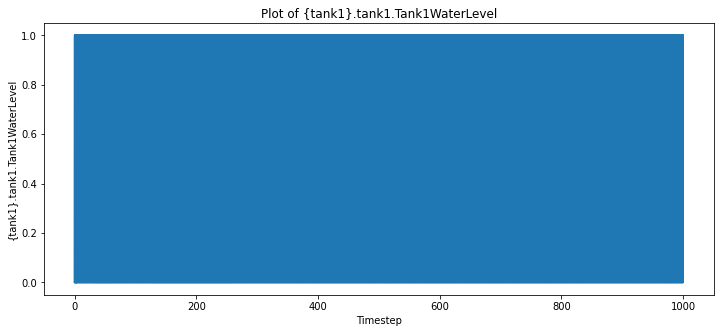

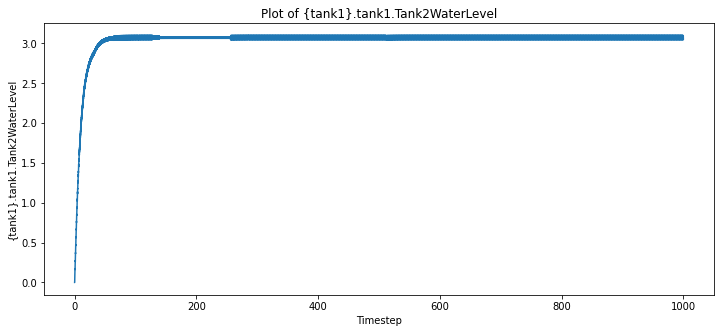

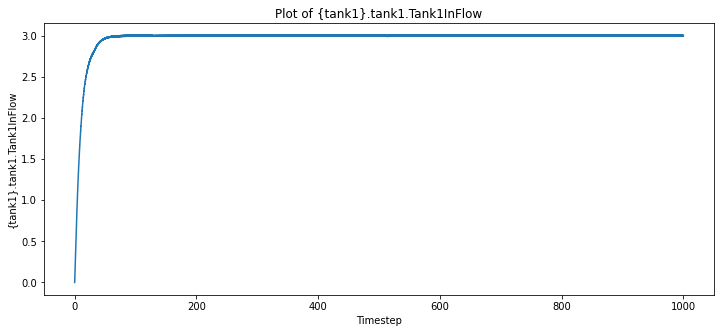

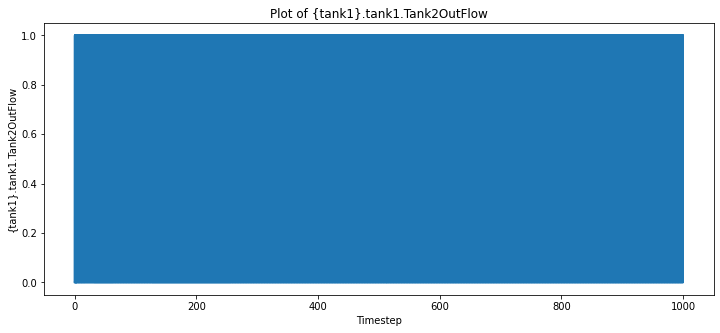

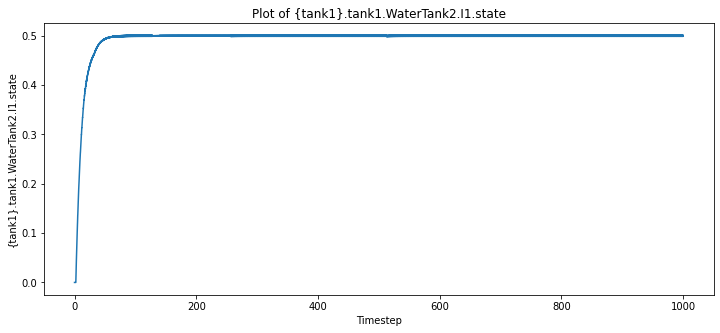

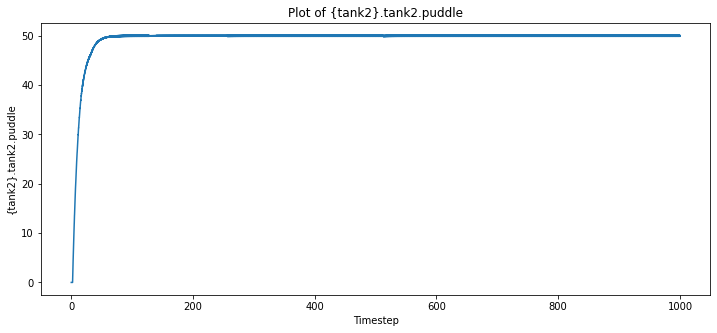

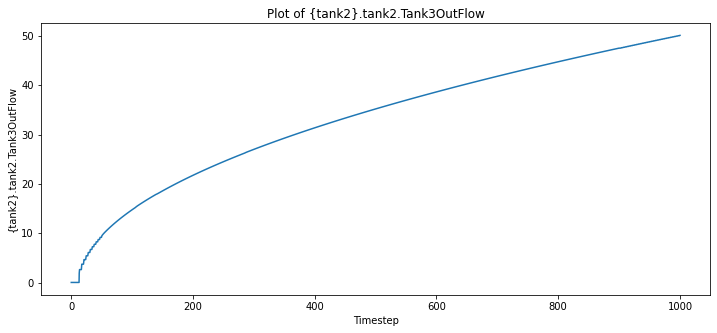

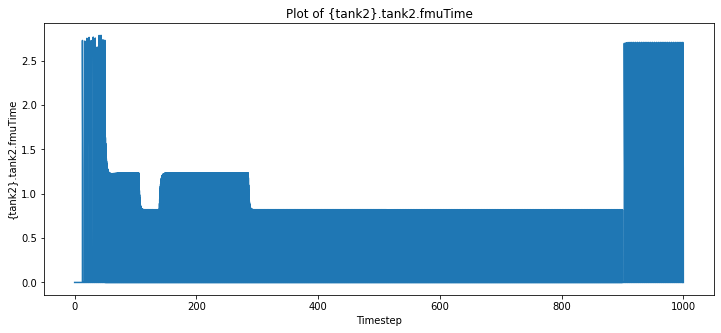

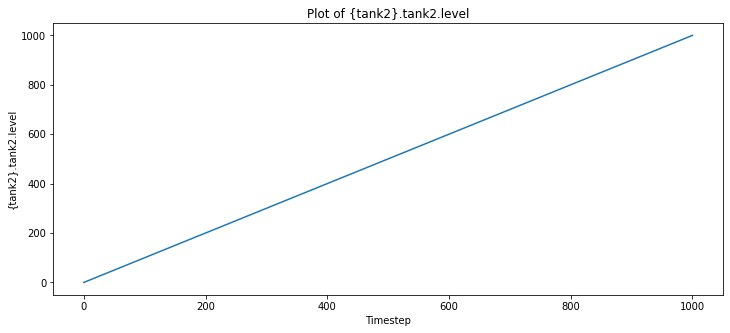

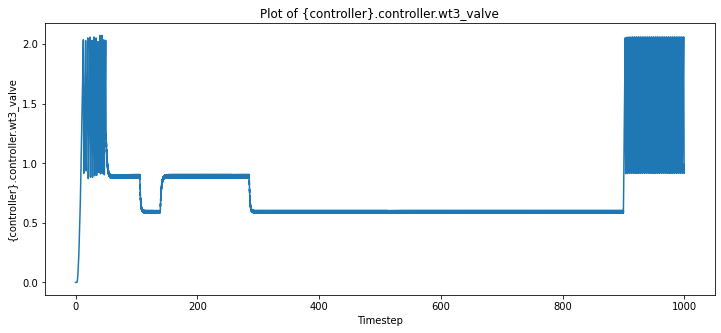

In [148]:
test_file = 'test_outputs.csv'
# test_file = 'stuckat1_training_reduced.csv'
# test_file = 'test_series_reduced.csv'
# dff = pd.read_csv(test_file, index_col=0, header=0, parse_dates=True)
dff = pd.read_csv(test_file, index_col=0, header=0)
featt = list(pd.read_csv(test_file, index_col=0, header=0).columns.values)[1:]
plot_series(dff, featt)

In [139]:
def plot_dataframe(df):
    num_series = len(df.columns)
    fig, axes = plt.subplots(num_series, 1, figsize=(10, 5*num_series), sharex=True)
    for i, col in enumerate(df.columns):
        ax = axes[i] if num_series > 1 else axes
        ax.plot(df.index, df[col])
        ax.set_title(col)
        ax.grid(True)

    plt.tight_layout()
    plt.show()